# Spark MLlib
## Lab assignment: Example with the MLlib

The aim of this notebook is to play with the MLlib of Apache Spark to create a Machine Learning pipeline that preprocess a dataset, train a model and make predictions. In particular, we are going to deal with a regression problem. The content of this lab has been inspired by the sample provided in the [DataBricks documentation](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2854662143668609/2084788691983918/6837869239396014/latest.html).


## Appliances Energy Prediction

**Data**: This dataset contains Energy consumption from appliances at 10 min resolution for about 4.5 months. The house temperature and humidity conditions were monitored with a wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes. Weather from the nearest airport weather station (Chievres Airport, Belgium) was also logged. This dataset is from [Candanedo et al](http://dx.doi.org/10.1016/j.enbuild.2017.01.083) and is hosted by the UCI Machine Learning Repository. [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction).


**Goal**: We want to learn to predict appliances' energy consumption based on weather information. It would also be nice to know which input features are the most relevant to make predictions.

**Approach**: We will use Spark ML Pipelines, which help users piece together parts of a workflow such as feature processing and model training. We will also demonstrate model selection (a.k.a. hyperparameter tuning) using Cross Validation in order to fine-tune and improve our ML model.

## Submission and marking criteria

You should complete this notebook and add your solutions to it. When you are done, rename your completed notebook as `ex04.ipynb`. 

Important notes:
- The **group leader** must submit the `ex04.ipynb` file on Moodle.
- **Each member of the group** must complete the peer review survey and their contribution statement using this [link](https://forms.office.com/Pages/ResponsePage.aspx?id=7qe9Z4D970GskTWEGCkKHjZupmfSK6JKqlvGZrucaoBURFJJWllYWVhQS09PMFNBVzlCT05JUjM4VCQlQCN0PWcu). **You can only submit this survey ONCE**.
- This lab is marked out of 100 marks, and each section is allocated a number of marks that are indicated below.
- The marking will be focused on the efficiency of the solution and its functionality. Minor mistakes will deduct marks from each exercise.

- **Submission deadline: 25th March 2022 at 3pm**

The first thing we need to do to start working with Spark is to initialize the `SparkSession`. We will also import a few libraries we will use. *Remember if you are using Databricks that `spark` and `sc` are already available to you and don't need initializing.*

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLlib lab") \
    .getOrCreate()

sc = spark.sparkContext

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.functions import col

# Helper function to test the correctness of the solutions
def test(var, val, msg=""):
    print("1 test passed.") if var == val else print("1 test failed. " + msg)

## Load and understand the data  [10 marks]

We begin by loading the data, which is in Comma-Separated Value (CSV) format. For that, you should use `spark.read` to read the file. Then, you should also cache the data so that we only read it from disk once.

In [0]:
# <FILL-IN WITH YOUR CODE>
df = spark.read.csv("/mnt/nogroup/data/energydata_complete.csv",header=True).cache()

# Cache your DataFrame
# <FILL-IN WITH YOUR CODE>


In [0]:
test(df.count(), 19735, 'Incorrect number of rows')
test(df.is_cached, True, 'df not cached')

1 test passed.
1 test passed.

#### Data description

From the UCI ML Repository description, we know that the columns have the following meanings.

**Attribute information**:
```
date time year-month-day hour:minute:second
Appliances, energy use in Wh
lights, energy use of light fixtures in the house in Wh
T1, Temperature in kitchen area, in Celsius
RH_1, Humidity in kitchen area, in %
T2, Temperature in living room area, in Celsius
RH_2, Humidity in living room area, in %
T3, Temperature in laundry room area
RH_3, Humidity in laundry room area, in %
T4, Temperature in office room, in Celsius
RH_4, Humidity in office room, in %
T5, Temperature in bathroom, in Celsius
RH_5, Humidity in bathroom, in %
T6, Temperature outside the building (north side), in Celsius
RH_6, Humidity outside the building (north side), in %
T7, Temperature in ironing room , in Celsius
RH_7, Humidity in ironing room, in %
T8, Temperature in teenager room 2, in Celsius
RH_8, Humidity in teenager room 2, in %
T9, Temperature in parents room, in Celsius
RH_9, Humidity in parents room, in %
To, Temperature outside (from Chievres weather station), in Celsius
Pressure (from Chievres weather station), in mm Hg
RH_out, Humidity outside (from Chievres weather station), in %
Wind speed (from Chievres weather station), in m/s
Visibility (from Chievres weather station), in km
Tdewpoint (from Chievres weather station), Â°C
rv1, Random variable 1, nondimensional
rv2, Random variable 2, nondimensional
```

**The target variable is the energy use of the Appliances.**

For now, we will leave the two variables `rv1` and `rv2` in our dataset, to see if they are affecting much our methods, then we can try to remove them and see if we improve the results.

Use `show` to visualise the data. Be careful not to show the entire data frame :-), only 5 rows!

In [0]:
# <FILL-IN WITH YOUR CODE>
df.show(5)

+-------------------+----------+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
 date|Appliances|lights| T1| RH_1| T2| RH_2| T3| RH_3| T4| RH_4| T5| RH_5| T6| RH_6| T7| RH_7| T8| RH_8| T9| RH_9| T_out| Press_mm_hg| RH_out| Windspeed| Visibility| Tdewpoint| rv1| rv2|
+-------------------+----------+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
2016-01-11 17:00:00| 60| 30|19.890000000000001|47.596666666666700|19.199999999999999|44.789999999999999|19.789999999999999|44.729999999999997|19.000000000000000|45.566666666666698|17.166666666666700|55.200000000000003| 7.02666666666666...|84.2566666666667032|17.199999999999999|41.626666666666701|18.199999999999999|48.899999999999999|17.033333333333299|45.530000000000001| 6.59999999999999...|733.50000000000000| 92.000000000000000| 7.00000000000000000|63.0000000000000000| 5.29999999999999...|13.27543315710499...|13.27543315710499...|
2016-01-11 17:10:00| 60| 30|19.890000000000001|46.693333333333300|19.199999999999999|44.722499999999997|19.789999999999999|44.789999999999999|19.000000000000000|45.992500000000000|17.166666666666700|55.200000000000003| 6.83333333333333...|84.0633333333333042|17.199999999999999|41.560000000000002|18.199999999999999|48.863333333333301|17.066666666666698|45.560000000000002| 6.48333333333332...|733.60000000000002| 92.000000000000000| 6.66666666666666963|59.1666666666666998| 5.20000000000000...|18.60619498183950...|18.60619498183950...|
2016-01-11 17:20:00| 50| 30|19.890000000000001|46.299999999999997|19.199999999999999|44.626666666666701|19.789999999999999|44.933333333333302|18.926666666666701|45.890000000000001|17.166666666666700|55.090000000000003| 6.55999999999999...|83.1566666666666947|17.199999999999999|41.433333333333302|18.199999999999999|48.729999999999997|17.000000000000000|45.500000000000000| 6.36666666666666...|733.70000000000005| 92.000000000000000| 6.33333333333333037|55.3333333333333002| 5.09999999999999...|28.64266816759482...|28.64266816759482...|
2016-01-11 17:30:00| 50| 40|19.890000000000001|46.066666666666698|19.199999999999999|44.590000000000003|19.789999999999999|45.000000000000000|18.890000000000001|45.723333333333301|17.166666666666700|55.090000000000003| 6.43333333333333...|83.4233333333333036|17.133333333333301|41.289999999999999|18.100000000000001|48.590000000000003|17.000000000000000|45.399999999999999| 6.25000000000000...|733.79999999999995| 92.000000000000000| 6.00000000000000000|51.5000000000000000| 5.00000000000000...|45.41038949973881...|45.41038949973881...|
2016-01-11 17:40:00| 60| 40|19.890000000000001|46.333333333333300|19.199999999999999|44.530000000000001|19.789999999999999|45.000000000000000|18.890000000000001|45.530000000000001|17.199999999999999|55.090000000000003| 6.36666666666666...|84.8933333333333024|17.199999999999999|41.229999999999997|18.100000000000001|48.590000000000003|17.000000000000000|45.399999999999999| 6.13333333333333...|733.89999999999998| 92.000000000000000| 5.66666666666666963|47.6666666666666998| 4.90000000000000...|10.08409655187278...|10.08409655187278...|
+-------------------+----

# Data preprocessing [10 marks]

This dataset is nicely prepared for Machine Learning and required very little preprocessing. However, rather than keeping the date as a timestamp, we would like to have some additional columns, including 'day of the year', 'hour', and 'month of the year'. Please use the naming `dayofyear`, `hour` and `month`, respectively.

**Hint**: Of course the SparkSQL library has a function to transform strings with datetime!

Would you like to have any other information from the datetime? Feel free to add other features.

In [0]:
# <FILL-IN WITH YOUR CODE>
df = df.select("*",F.dayofyear("date").alias('dayofyear'),F.hour("date").alias('hour'),F.month("date").alias('month'))

When you dataframe `df` has the additional columns, please remove the column `date`:

In [0]:
# <FILL-IN WITH YOUR CODE>
df = df.drop("date")
df.select("*").show(5)

+----------+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+---------+----+-----+
Appliances|lights| T1| RH_1| T2| RH_2| T3| RH_3| T4| RH_4| T5| RH_5| T6| RH_6| T7| RH_7| T8| RH_8| T9| RH_9| T_out| Press_mm_hg| RH_out| Windspeed| Visibility| Tdewpoint| rv1| rv2|dayofyear|hour|month|
+----------+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+---------+----+-----+
 60| 30|19.890000000000001|47.596666666666700|19.199999999999999|44.789999999999999|19.789999999999999|44.729999999999997|19.000000000000000|45.566666666666698|17.166666666666700|55.200000000000003| 7.02666666666666...|84.2566666666667032|17.199999999999999|41.626666666666701|18.199999999999999|48.899999999999999|17.033333333333299|45.530000000000001| 6.59999999999999...|733.50000000000000| 92.000000000000000| 7.00000000000000000|63.0000000000000000| 5.29999999999999...|13.27543315710499...|13.27543315710499...| 11| 17| 1|
 60| 30|19.890000000000001|46.693333333333300|19.199999999999999|44.722499999999997|19.789999999999999|44.789999999999999|19.000000000000000|45.992500000000000|17.166666666666700|55.200000000000003| 6.83333333333333...|84.0633333333333042|17.199999999999999|41.560000000000002|18.199999999999999|48.863333333333301|17.066666666666698|45.560000000000002| 6.48333333333332...|733.60000000000002| 92.000000000000000| 6.66666666666666963|59.1666666666666998| 5.20000000000000...|18.60619498183950...|18.60619498183950...| 11| 17| 1|
 50| 30|19.890000000000001|46.299999999999997|19.199999999999999|44.626666666666701|19.789999999999999|44.933333333333302|18.926666666666701|45.890000000000001|17.166666666666700|55.090000000000003| 6.55999999999999...|83.1566666666666947|17.199999999999999|41.433333333333302|18.199999999999999|48.729999999999997|17.000000000000000|45.500000000000000| 6.36666666666666...|733.70000000000005| 92.000000000000000| 6.33333333333333037|55.3333333333333002| 5.09999999999999...|28.64266816759482...|28.64266816759482...| 11| 17| 1|
 50| 40|19.890000000000001|46.066666666666698|19.199999999999999|44.590000000000003|19.789999999999999|45.000000000000000|18.890000000000001|45.723333333333301|17.166666666666700|55.090000000000003| 6.43333333333333...|83.4233333333333036|17.133333333333301|41.289999999999999|18.100000000000001|48.590000000000003|17.000000000000000|45.399999999999999| 6.25000000000000...|733.79999999999995| 92.000000000000000| 6.00000000000000000|51.5000000000000000| 5.00000000000000...|45.41038949973881...|45.41038949973881...| 11| 17| 1|
 60| 40|19.890000000000001|46.333333333333300|19.199999999999999|44.530000000000001|19.789999999999999|45.000000000000000|18.890000000000001|45.530000000000001|17.199999999999999|55.090000000000003| 6.36666666666666...|84.8933333333333024|17.199999999999999|41.229999999999997|18.100000000000001|48.590000000000003|17.000000000000000|45.399999999999999| 6.13333333333333...|733.89999999999998| 92.000000000000000| 5.66666666666666963|47.6666666666666998| 4.90000000000000...|10.08409655187278...|10.08409655187278...| 11| 17| 1|
+----------+------+------------------+---------------

In [0]:
test("date" in df.columns, False, "Column date has not been remove!")
test("hour" in df.columns, True, "The hour hasn't been added")
test("dayofyear" in df.columns, True, "The dayofyear hasn't been added")
test("month" in df.columns, True, "The month hasn't been added")

1 test passed.
1 test passed.
1 test passed.
1 test passed.

Check the schema of your dataframe:

In [0]:
# <FILL-IN WITH YOUR CODE>
df.printSchema()

root
-- Appliances: string (nullable = true)
-- lights: string (nullable = true)
-- T1: string (nullable = true)
-- RH_1: string (nullable = true)
-- T2: string (nullable = true)
-- RH_2: string (nullable = true)
-- T3: string (nullable = true)
-- RH_3: string (nullable = true)
-- T4: string (nullable = true)
-- RH_4: string (nullable = true)
-- T5: string (nullable = true)
-- RH_5: string (nullable = true)
-- T6: string (nullable = true)
-- RH_6: string (nullable = true)
-- T7: string (nullable = true)
-- RH_7: string (nullable = true)
-- T8: string (nullable = true)
-- RH_8: string (nullable = true)
-- T9: string (nullable = true)
-- RH_9: string (nullable = true)
-- T_out: string (nullable = true)
-- Press_mm_hg: string (nullable = true)
-- RH_out: string (nullable = true)
-- Windspeed: string (nullable = true)
-- Visibility: string (nullable = true)
-- Tdewpoint: string (nullable = true)
-- rv1: string (nullable = true)
-- rv2: string (nullable = true)
-- dayofyear: integer (nullable = true)
-- hour: integer (nullable = true)
-- month: integer (nullable = true)

Dammit, all the input features have been inferred as strings rather than numeric values. This is because we read the data from a CSV file with the data in between quotes.

Your task now is to transform that into numerical values. All of the features are actually numeric, so you could cast all of them. You are recommended to use functions like `cast` and `col` to do this. You could try to leave out the datetime columns we created, but it's fine if you transform them to float.

In [0]:
# <FILL-IN WITH YOUR CODE>
df = df.select([col(c).cast("float") for c in df.columns[:-3]] + [col(c) for c in df.columns[-3:]])

In [0]:
#print the schema again.
# <FILL-IN WITH YOUR CODE>
df.printSchema()

root
-- Appliances: float (nullable = true)
-- lights: float (nullable = true)
-- T1: float (nullable = true)
-- RH_1: float (nullable = true)
-- T2: float (nullable = true)
-- RH_2: float (nullable = true)
-- T3: float (nullable = true)
-- RH_3: float (nullable = true)
-- T4: float (nullable = true)
-- RH_4: float (nullable = true)
-- T5: float (nullable = true)
-- RH_5: float (nullable = true)
-- T6: float (nullable = true)
-- RH_6: float (nullable = true)
-- T7: float (nullable = true)
-- RH_7: float (nullable = true)
-- T8: float (nullable = true)
-- RH_8: float (nullable = true)
-- T9: float (nullable = true)
-- RH_9: float (nullable = true)
-- T_out: float (nullable = true)
-- Press_mm_hg: float (nullable = true)
-- RH_out: float (nullable = true)
-- Windspeed: float (nullable = true)
-- Visibility: float (nullable = true)
-- Tdewpoint: float (nullable = true)
-- rv1: float (nullable = true)
-- rv2: float (nullable = true)
-- dayofyear: integer (nullable = true)
-- hour: integer (nullable = true)
-- month: integer (nullable = true)

## Split data into training and test sets [10 marks]

Our final data preparation step is to split our dataset into training and test sets. We will train and tune our model on the training set, and then see how well we do in the test.

Your task is to split the dataframe `df` into 70% for training and 30% for test. Please use the same random seed.

In [0]:
# <FILL-IN WITH YOUR CODE>
seed = 123
train, test = df.randomSplit([0.7,0.3],seed)

Even though we have fixed the random seed, you will not get the exact same split.

Note that this is the simplest way of validating your results. You may want to carry out a [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) and split the dataset into *k* folds, and build and test *k* models. We will do later cross validation but for parameter tuning! not to validate our approach!

## Data visualisation [10 marks]

Before applying any machine learning algorithm, it is a good practice to try to visualise your data. For example, we could see how much energy is spent in appliances depending on the month.

In [0]:
# create a variable `hist_elect` that contains the histogram of total energy consumed by the Appliances, grouped by month
# <FILL-IN WITH YOUR CODE>
hist_elect = df.groupBy('month').agg(F.sum(df['Appliances'])).collect()

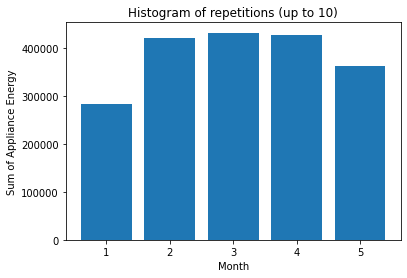

In [0]:
(x_values, y_values) = zip(*hist_elect)
plt.bar(x_values, y_values)
plt.title('Histogram of repetitions (up to 10)')
plt.xlabel('Month')
plt.ylabel('Sum of Appliance Energy')
plt.show()

As we don't seem to have all the data from the 1st of January, well, we have less consumption in that particular months, so probably the month is not a good feature, don't you think? we are going to remove it from the dataframe and the training and test data frames too!

In [0]:
# update the variables `df`, `train` and `test`, removing the column 'month'
# <FILL-IN WITH YOUR CODE>
df = df.drop('month')
train = train.drop('month')
test = test.drop('month')

You could do other plots to understand better the data and practice with Spark :-). This is a good opportunity to practice with the DataFrame API, although if you are running this on Databricks, some plots can be generated very easily by yourself.

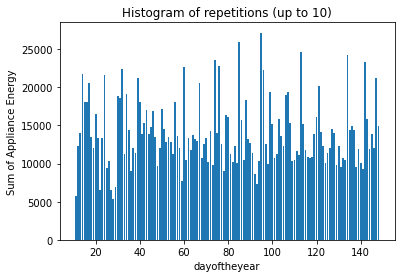

In [0]:
# <FILL-IN WITH YOUR CODE>
hist_elect = df.groupBy('dayofyear').agg(F.sum(df['Appliances'])).collect()
(x_values, y_values) = zip(*hist_elect)
plt.bar(x_values, y_values)
plt.title('Histogram of repetitions (up to 10)')
plt.xlabel('dayoftheyear')
plt.ylabel('Sum of Appliance Energy')
plt.show()

## Create a Pipeline with Spark ML [20 marks]

As you know, we can't feed the data frame directly to a machine learning algorithm, as we need to put all the input features as an Array, and indicate which one is the output feature (in our case, the 'Appliances' column!).

We will put together a simple Pipeline with the following stages:

- VectorAssembler: To combine all the input columns into a single vector column (i.e. all the columns but the 'Appliances' one.
- Learning algorithm: I feel like using Gradient-Boosted Trees [GBTs](https://en.wikipedia.org/wiki/Gradient_boosting) for this example, but feel free to use anything else.
- CrossValidator: I will use cross validation to tune the parameters of the GBT model. Yes, this can be added as part of a pipeline!  This is going to change the way we access the best model later!

Step 1: Create the `VectorAssembler`:

In [0]:
from pyspark.ml.feature import VectorAssembler

# <FILL-IN WITH YOUR CODE>
features = train.columns
features.remove("Appliances")
# features

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_combined_features = assembler.transform(train)

df_combined_features.printSchema()

root
-- Appliances: float (nullable = true)
-- lights: float (nullable = true)
-- T1: float (nullable = true)
-- RH_1: float (nullable = true)
-- T2: float (nullable = true)
-- RH_2: float (nullable = true)
-- T3: float (nullable = true)
-- RH_3: float (nullable = true)
-- T4: float (nullable = true)
-- RH_4: float (nullable = true)
-- T5: float (nullable = true)
-- RH_5: float (nullable = true)
-- T6: float (nullable = true)
-- RH_6: float (nullable = true)
-- T7: float (nullable = true)
-- RH_7: float (nullable = true)
-- T8: float (nullable = true)
-- RH_8: float (nullable = true)
-- T9: float (nullable = true)
-- RH_9: float (nullable = true)
-- T_out: float (nullable = true)
-- Press_mm_hg: float (nullable = true)
-- RH_out: float (nullable = true)
-- Windspeed: float (nullable = true)
-- Visibility: float (nullable = true)
-- Tdewpoint: float (nullable = true)
-- rv1: float (nullable = true)
-- rv2: float (nullable = true)
-- dayofyear: integer (nullable = true)
-- hour: integer (nullable = true)
-- features: vector (nullable = true)

In [0]:
df_combined_features.select('features').show()

+--------------------+
 features|
+--------------------+
[0.0,17.290000915...|
[0.0,18.0,43.7000...|
[0.0,19.0,39.3266...|
[0.0,19.0,47.1266...|
[0.0,19.100000381...|
[0.0,20.290000915...|
[10.0,20.70000076...|
[0.0,17.200000762...|
[0.0,17.290000915...|
[0.0,17.290000915...|
[0.0,17.290000915...|
[0.0,17.389999389...|
[0.0,17.5,41.5600...|
[0.0,17.5,41.6633...|
[0.0,17.600000381...|
[0.0,17.600000381...|
[0.0,17.666666030...|
[0.0,17.790000915...|
[0.0,17.889999389...|
[0.0,17.889999389...|
+--------------------+
only showing top 20 rows

Step 2: Create an instance of `GBTRegressor` in which you don't indicate any parameters but the class label (i.e. `labelCol`) to 'Appliances'.

In [0]:
from pyspark.ml.regression import GBTRegressor

#name the variable `gbt` 
# <FILL-IN WITH YOUR CODE>

gbt = GBTRegressor(labelCol="Appliances")

Step 3: Create a `CrossValidator` for `gbt`.

You can explore the parameters you like for GBT. Full documentation [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html). I would suggest to create a 'grid' for at least the depth of the tree and the number of iterations. Don't investigate more than 4-8 combinations! :-)

Import the right libraries:

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [0]:
# define a variable `paramGrid` with some parameters, e.g. for maxDepth, range [5,8], and for maxIter [10,20]

# <FILL-IN WITH YOUR CODE>
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [5,6,7,8]).addGrid(gbt.maxIter, [10,20]).build()
paramGrid

Out[65]: [{Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 10},
 {Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 20},
 {Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 10},
 {Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 6,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 20},
 {Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 10},
 {Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 20},
 {Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 10},
 {Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 8,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 20}]

Create a RegressionEvaluator that uses the [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as our performance metric. Import the right package first:

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

In [0]:
# create a variable `evaluator` with a rmse as metric for the prediction column given by `gbt`.
# <FILL-IN WITH YOUR CODE>
evaluator = RegressionEvaluator()
evaluator.setPredictionCol("prediction")
evaluator.setLabelCol("Appliances")
evaluator.setMetricName("rmse")

Out[67]: RegressionEvaluator_84ccb53f9cc2

We can now create a CrossValidator `cv` that uses the `gbt` as estimator, as well as the evaluator and grid we defined above.

In [0]:
# <FILL-IN WITH YOUR CODE>
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, collectSubModels=True)

Step 4. Create a Pipeline (`pipeline`) that contains the two stages: `vectorAssembler` and `cv`

In [0]:
from pyspark.ml import Pipeline

# <FILL-IN WITH YOUR CODE>
pipeline = Pipeline(stages=[assembler, cv])

Step 5. Finally, `fit` the model, and store in a `pipelineModel` variable. This might take quite a bit of time!

In [0]:
# <FILL-IN WITH YOUR CODE>
pipeline_model = pipeline.fit(train)

In [0]:
cvModel = pipeline_model.stages[1]

In [0]:
cvModel.bestModel.extractParamMap()

Out[94]: {Param(parent='GBTRegressor_fa2e1bb85305', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTRegressor_fa2e1bb85305', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTRegressor_fa2e1bb85305', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'all',
 Param(parent='GBTRegressor_fa2e1bb85305', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='GBTRegressor_fa2e1bb85305', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance',
 Param(parent='GBTRegressor_fa2e1bb85305', name='labelCol', doc='label column name.'): 'Appliances',
 Param(parent='GBTRegressor_fa2e1bb85305', name='leafCol', doc='Leaf indices column name. Predicted leaf index of each instance in each tree by preorder.'): '',
 Param(parent='GBTRegressor_fa2e1bb85305', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute'): 'squared',
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 20,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size.'): 256,
 Param(parent='GBTRegressor_fa2e1bb85305', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(parent='GBTRegressor_fa2e1bb85305', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1,
 Param(parent='GBTRegressor_fa2e1bb85305', name='minWeightFractionPerNode', doc='Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5).'): 0.0,
 Param(parent='GBTRegressor_fa2e1bb85305', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='GBTRegressor_fa2e1bb85305', name='seed', doc='random seed.'): -6682481135904123338,
 Param(parent='GBTRegressor_fa2e1bb85305', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1,
 Param(parent='GBTRegressor_fa2e1bb853

In [0]:
cvModel.subModels[0][5].extractParamMap()

Out[108]: {Param(parent='GBTRegressor_fa2e1bb85305', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTRegressor_fa2e1bb85305', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTRegressor_fa2e1bb85305', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'all',
 Param(parent='GBTRegressor_fa2e1bb85305', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='GBTRegressor_fa2e1bb85305', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance'): 'variance',
 Param(parent='GBTRegressor_fa2e1bb85305', name='labelCol', doc='label column name.'): 'Appliances',
 Param(parent='GBTRegressor_fa2e1bb85305', name='leafCol', doc='Leaf indices column name. Predicted leaf index of each instance in each tree by preorder.'): '',
 Param(parent='GBTRegressor_fa2e1bb85305', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: squared, absolute'): 'squared',
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxIter', doc='max number of iterations (>= 0).'): 20,
 Param(parent='GBTRegressor_fa2e1bb85305', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size.'): 256,
 Param(parent='GBTRegressor_fa2e1bb85305', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(parent='GBTRegressor_fa2e1bb85305', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1,
 Param(parent='GBTRegressor_fa2e1bb85305', name='minWeightFractionPerNode', doc='Minimum fraction of the weighted sample count that each child must have after split. If a split causes the fraction of the total weight in the left or right child to be less than minWeightFractionPerNode, the split will be discarded as invalid. Should be in interval [0.0, 0.5).'): 0.0,
 Param(parent='GBTRegressor_fa2e1bb85305', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='GBTRegressor_fa2e1bb85305', name='seed', doc='random seed.'): -6682481135904123338,
 Param(parent='GBTRegressor_fa2e1bb85305', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1,
 Param(parent='GBTRegressor_fa2e1bb85

In [0]:
cvModel.avgMetrics

Out[104]: [86.84280062980156,
 84.34266340899734,
 85.76180350553024,
 83.1582592992126,
 84.91549745233341,
 82.67419416176351,
 85.85426027452165,
 84.21022028415041]

d
It could be a good idea to save this to disk, in case it takes too long, so we can read it later.

In [0]:
pipeline_model.save("mnt/nogroup/Model-lab4")

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-2982402517177169> in <module> 
 ----> 1 pipeline_model . save ( "mnt/nogroup/Model-lab4" ) 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 355 def save ( self , path ) : 
 356 """Save this ML instance to the given path, a shortcut of 'write().save(path)'.""" 
 --> 357 self . write ( ) . save ( path ) 
 358 
 359 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 251 if self . shouldOverwrite : 
 252 self . _handleOverwrite ( path ) 
 --> 253 self . saveImpl ( path ) 
 254 
 255 def saveImpl ( self , path ) : 

 /databricks/spark/python/pyspark/ml/pipeline.py in saveImpl (self, path) 
 240 stages = self . instance . stages
 241 PipelineSharedReadWrite . validateStages ( stages ) 
 --> 242 PipelineSharedReadWrite . saveImpl ( self . instance , stages , self . sc , path ) 
 243 
 244 

 /databricks/spark/python/pyspark/ml/pipeline.py in saveImpl (instance, stages, sc, path) 
 372 stageUids = [ stage . uid for stage in stages ] 
 373 jsonParams = { 'stageUids' : stageUids , 'language' : 'Python' } 
 --> 374 DefaultParamsWriter . saveMetadata ( instance , path , sc , paramMap = jsonParams ) 
 375 stagesDir = os . path . join ( path , "stages" ) 
 376 for index , stage in enumerate ( stages ) : 

 /databricks/spark/python/pyspark/ml/util.py in saveMetadata (instance, path, sc, extraMetadata, paramMap) 
 549 extraMetadata , 
 550 paramMap)
 --> 551 sc . parallelize ( [ metadataJson ] , 1 ) . saveAsTextFile ( metadataPath ) 
 552 
 553 @ staticmethod

 /databricks/spark/python/pyspark/rdd.py in saveAsTextFile (self, path, compressionCodecClass) 
 1860 self . ctx . _jvm . PythonRDD . saveAsTextFileImpl ( keyed . _jrdd , path , compressionCodecClass ) 
 1861 else : 
 -> 1862 self . ctx . _jvm . PythonRDD . saveAsTextFileImpl ( keyed . _jrdd , path ) 
 1863 
 1864 # Pair functions 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 115 def deco ( * a , ** kw ) : 
 116 try : 
 --> 117 return f ( * a , ** kw ) 
 118 except py4j . protocol . Py4JJavaError as e : 
 119 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.saveAsTextFileImpl.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory dbfs:/mnt/nogroup/Model-lab4/metadata already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:303)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:75)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	at org.apache.sp

## Evaluate the results [10 marks]

To obtain the predictions in the test set, apply the method `transform()` of the trained pipeline on the test DataFrame! This will not apply the cross-validation of course!

In [0]:
# create a variable `predictions`:

# <FILL-IN WITH YOUR CODE>
predictions = pipeline_model.transform(test)
predictions.show(10)

+----------+------+-----+---------+---------+---------+---------+---------+-----+---------+---------+---------+----------+---------+---------+---------+---------+---------+-----+---------+---------+-----------+---------+---------+----------+---------+---------+---------+---------+----+--------------------+-----------------+
Appliances|lights| T1| RH_1| T2| RH_2| T3| RH_3| T4| RH_4| T5| RH_5| T6| RH_6| T7| RH_7| T8| RH_8| T9| RH_9| T_out|Press_mm_hg| RH_out|Windspeed|Visibility|Tdewpoint| rv1| rv2|dayofyear|hour| features| prediction|
+----------+------+-----+---------+---------+---------+---------+---------+-----+---------+---------+---------+----------+---------+---------+---------+---------+---------+-----+---------+---------+-----------+---------+---------+----------+---------+---------+---------+---------+----+--------------------+-----------------+
 10.0| 0.0| 18.7| 46.345| 17.89| 46.4| 19.7| 44.79|17.76| 46.9| 17.29| 53.045| 3.4333334| 95.53| 17.29| 43.29| 17.39|49.610554| 16.7| 47.4| 4.2| 763.36664|92.333336| 2.0| 28.333334|3.0333333|13.031552|13.031552| 28| 8|[0.0,18.700000762...|47.64899697717735|
 10.0| 0.0|19.23| 39.03| 17.79| 39.5| 19.7| 40.5675| 18.6|38.163334| 17.1| 60.145|-4.9055557| 86.76778|17.633333| 33.9| 19.5| 45.09|16.79| 41.29| -4.1| 756.2833| 89.0| 1.0| 64.0| -5.7|19.337233|19.337233| 19| 4|[0.0,19.229999542...|39.47930281035823|
 20.0| 0.0| 17.2|43.326668| 16.29| 43.7| 17.6| 41.5| 15.3| 42.9| 15.5| 49.09| 6.0933332| 99.9| 15.69| 38.5|16.583334|46.375557| 15.1| 42.9| 5.65| 767.73334| 99.0|3.1666667| 42.333332|5.5333333| 5.081045| 5.081045| 23| 7|[0.0,17.200000762...|53.70739147886853|
 20.0| 0.0|17.29| 42.7| 16.39| 42.9| 17.7| 40.9|15.39| 42.09| 15.6| 48.79| 5.59| 99.9|15.769444| 37.59| 16.705|45.405556|15.19| 41.9|5.0666666| 766.1667|99.666664|3.6666667| 8.333333|5.0333333|49.530025|49.530025| 23| 4|[0.0,17.290000915...|31.40501313478719|
 20.0| 0.0|17.29| 42.76| 16.39|42.966667| 17.76|40.933334|15.39| 42.09| 15.6| 48.79| 5.6566668| 99.9|15.775556| 37.63278| 16.7|45.466667|15.19|41.966667|5.0833335| 766.23334|99.833336|3.8333333| 9.666667|5.0666666|35.718266|35.718266| 23| 4|[0.0,17.290000915...|31.40501313478719|
 20.0| 0.0| 17.5| 41.59|16.566668| 42.09| 17.89| 40.4| 15.5| 41.2| 15.69| 48.585| 5.1233335| 99.9| 15.835|36.612778|16.908333| 44.4| 15.3| 41.0| 4.65| 763.68335| 100.0|3.8333333| 3.6666667| 4.65|4.4680457|4.4680457| 23| 1|[0.0,17.5,41.5900...|32.90864851884998|
 20.0| 0.0|17.79| 40.7| 16.7| 41.23|18.033333| 40.09|15.69| 40.4| 15.82|48.314445| 3.79| 99.5|15.963333| 35.7| 17.2|43.483334| 15.5| 40.23| 3.7| 761.9667|97.666664|5.3333335| 42.333332|3.3333333|16.753036|16.753036| 22| 21|[0.0,17.790000915...|50.47903946718675|
 20.0| 0.0|17.89| 44.29|17.133333| 44.7|19.066668|42.163334|16.79| 44.5|16.633333| 50.22389| 8.6| 82.39333| 17.0| 39.79| 17.1| 46.5|16.23| 44.03| 8.2| 763.2|82.333336|10.666667| 40.0| 5.3|28.610325|28.610325| 29| 13|[0.0,17.889999389...|55.94323521410797|
 20.0| 0.0|17.89| 44.79| 17.1| 45.0| 19.0| 42.4|16.79| 45.0| 16.6| 50.2| 8.69| 84.82333|16.975555| 40.33278|17.022223| 47.03| 16.2| 44.5| 8.4| 762.6| 84.5| 10.0| 40.0| 5.9|31.429195|31.429195| 29| 15|[0.0,17.889999389...|47.45294134294672|
 20.0| 0.0| 18.0|43.663334| 17.2| 44.2| 19.1| 42.09|16.89| 44.0| 16.7| 50.29| 7.5|82.833336| 17.05| 39.245|17.133333|45.663334|16.29| 43.5| 7.0| 763.76666| 81.0| 8.333333| 40.0|3.9666667|22.793861|22.793861| 29| 11|[0.0,18.0,43.6633...| 66.7749103584566|
+----------+------+-----+---------+---------+---------+---------+---------+-----+---------+---------+---------+----------+---------+---------+---------+---------+---------+-----+---------+---------+-----------+---------+---------+----------+---------+---------+---------+---------+----+--------------------+-----------------+
only showing top 10 rows

It is easier to view the results when we limit the columns displayed to:

- `Appliances`: the consumption of the Appliances in Wh
- `prediction`: our predicted prediction

Find a way to show the output only for these two features (only for the first 5 rows):

In [0]:
# <FILL-IN WITH YOUR CODE>
predictions.select("Appliances","prediction").show(5)

+----------+-----------------+
Appliances| prediction|
+----------+-----------------+
 10.0|47.64899697717735|
 10.0|39.47930281035823|
 20.0|53.70739147886853|
 20.0|31.40501313478719|
 20.0|31.40501313478719|
+----------+-----------------+
only showing top 5 rows

Are these results any good? Let's compute the RMSE using the evaluator we created before! Store the result in a `rmse` variable.

In [0]:
# <FILL-IN WITH YOUR CODE>
rmse = evaluator.evaluate(predictions)

In [0]:
print(rmse)

83.99832348918864

Seems a bit high?  Well, this number is closer to what it is reported in the original paper with RF (RMSE around 69).

But maybe you can investigate a bit more if you can improve that. Can you find out the importance of the features from the GBTs?

You first need to find out the best model!! In the way we trained the pipeline, you can find the trained cvModel as one of the stages of the `pipelineModel`:

In [0]:
cvModel = pipeline_model.stages[1]

In [0]:
cvModel.bestModel

Out[394]: GBTRegressionModel: uid=GBTRegressor_7396a854c604, numTrees=20, numFeatures=29

Check the feature importances of that `cvModel`:

In [0]:
cvModel.bestModel.featureImportances

Out[395]: SparseVector(29, {0: 0.0276, 1: 0.0625, 2: 0.0442, 3: 0.0379, 4: 0.0491, 5: 0.0441, 6: 0.0523, 7: 0.0318, 8: 0.0356, 9: 0.021, 10: 0.0407, 11: 0.0329, 12: 0.0302, 13: 0.0167, 14: 0.0169, 15: 0.0365, 16: 0.0363, 17: 0.0241, 18: 0.0285, 19: 0.0205, 20: 0.0377, 21: 0.0341, 22: 0.0438, 23: 0.031, 24: 0.0186, 25: 0.0391, 27: 0.0249, 28: 0.0813})

Uhm, looks like our model gave feature #28 quite a bit of importance, which is the hour of the day if I recall correctly.  Features #25 and #26 were random, and the model noticed that 26 was completely useless, but gave some importance to 'rv1'. GBTs perform somehow an implicit feature selection, so those low importance features won't affect much their performance, but I wonder if we could just remove low importance features?

*Task*: Create a list of those features with less than for example 0.05.

In [0]:
pairs = cvModel.bestModel.featureImportances

In [0]:
# create a list `to_remove` that contains the feature names that must be removed because their confidence is less than 0.05 
# <FILL-IN WITH YOUR CODE>
to_remove = []
column_names = predictions.columns
pairs_arr = pairs.toArray()
for i in range (len(pairs_arr)):
  if pairs_arr[i] < 0.05:
    to_remove.append(column_names[i+1])
# for x in pairs:
#   print(x.key)


In [0]:
print(to_remove)

['lights', 'RH_1', 'T2', 'RH_2', 'T3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'dayofyear']

## Removing low importance features [10 marks]

Check the current schema of the training data:

In [0]:
# <FILL-IN WITH YOUR CODE>
train.printSchema()

root
-- Appliances: float (nullable = true)
-- lights: float (nullable = true)
-- T1: float (nullable = true)
-- RH_1: float (nullable = true)
-- T2: float (nullable = true)
-- RH_2: float (nullable = true)
-- T3: float (nullable = true)
-- RH_3: float (nullable = true)
-- T4: float (nullable = true)
-- RH_4: float (nullable = true)
-- T5: float (nullable = true)
-- RH_5: float (nullable = true)
-- T6: float (nullable = true)
-- RH_6: float (nullable = true)
-- T7: float (nullable = true)
-- RH_7: float (nullable = true)
-- T8: float (nullable = true)
-- RH_8: float (nullable = true)
-- T9: float (nullable = true)
-- RH_9: float (nullable = true)
-- T_out: float (nullable = true)
-- Press_mm_hg: float (nullable = true)
-- RH_out: float (nullable = true)
-- Windspeed: float (nullable = true)
-- Visibility: float (nullable = true)
-- Tdewpoint: float (nullable = true)
-- rv1: float (nullable = true)
-- rv2: float (nullable = true)
-- dayofyear: integer (nullable = true)
-- hour: integer (nullable = true)

You don't need to remove the columns from train and test partitions as you won't be able to re-train the pipeline without modifying the VectorAssemble. You simply need to indicate the columns you want to use when creating a new `vectorAssembler2`:

In [0]:
# <FILL-IN WITH YOUR CODE>
features = train.columns
for feature in to_remove:
  features.remove(feature)
features.remove("Appliances")

assembler2 = VectorAssembler(inputCols=features, outputCol="features")

and create a new pipeline, `pipeline2`, with that new `vectorAssemble2`:

In [0]:
# <FILL-IN WITH YOUR CODE>
pipeline2 = Pipeline(stages=[assembler2, cv])

And `fit` the new pipeline:

In [0]:
# <FILL-IN WITH YOUR CODE>
pipeline_model2 = pipeline2.fit(train)

In [0]:
pipeline_model2.save("mnt/nogroup/Model-lab4-second")

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-3310348366446972> in <module> 
 ----> 1 pipeline_model2 . save ( "mnt/nogroup/Model-lab4-second" ) 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 355 def save ( self , path ) : 
 356 """Save this ML instance to the given path, a shortcut of 'write().save(path)'.""" 
 --> 357 self . write ( ) . save ( path ) 
 358 
 359 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 251 if self . shouldOverwrite : 
 252 self . _handleOverwrite ( path ) 
 --> 253 self . saveImpl ( path ) 
 254 
 255 def saveImpl ( self , path ) : 

 /databricks/spark/python/pyspark/ml/pipeline.py in saveImpl (self, path) 
 240 stages = self . instance . stages
 241 PipelineSharedReadWrite . validateStages ( stages ) 
 --> 242 PipelineSharedReadWrite . saveImpl ( self . instance , stages , self . sc , path ) 
 243 
 244 

 /databricks/spark/python/pyspark/ml/pipeline.py in saveImpl (instance, stages, sc, path) 
 372 stageUids = [ stage . uid for stage in stages ] 
 373 jsonParams = { 'stageUids' : stageUids , 'language' : 'Python' } 
 --> 374 DefaultParamsWriter . saveMetadata ( instance , path , sc , paramMap = jsonParams ) 
 375 stagesDir = os . path . join ( path , "stages" ) 
 376 for index , stage in enumerate ( stages ) : 

 /databricks/spark/python/pyspark/ml/util.py in saveMetadata (instance, path, sc, extraMetadata, paramMap) 
 549 extraMetadata , 
 550 paramMap)
 --> 551 sc . parallelize ( [ metadataJson ] , 1 ) . saveAsTextFile ( metadataPath ) 
 552 
 553 @ staticmethod

 /databricks/spark/python/pyspark/rdd.py in saveAsTextFile (self, path, compressionCodecClass) 
 1860 self . ctx . _jvm . PythonRDD . saveAsTextFileImpl ( keyed . _jrdd , path , compressionCodecClass ) 
 1861 else : 
 -> 1862 self . ctx . _jvm . PythonRDD . saveAsTextFileImpl ( keyed . _jrdd , path ) 
 1863 
 1864 # Pair functions 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 115 def deco ( * a , ** kw ) : 
 116 try : 
 --> 117 return f ( * a , ** kw ) 
 118 except py4j . protocol . Py4JJavaError as e : 
 119 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.saveAsTextFileImpl.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory dbfs:/mnt/nogroup/Model-lab4-second/metadata already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:303)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:75)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:419)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1088)
	a

Finally, make predictions and compute the error:

In [0]:
# <FILL-IN WITH YOUR CODE>
predictions = pipeline_model2.transform(test)
rmse = evaluator.evaluate(predictions)

In [0]:
predictions.select("Appliances","prediction").show(5)
print(rmse)

+----------+------------------+
Appliances| prediction|
+----------+------------------+
 10.0| 51.87324447800486|
 10.0|41.075736418723956|
 20.0|37.286539302600495|
 20.0| 44.90328149046414|
 20.0| 44.90328149046414|
+----------+------------------+
only showing top 5 rows

90.52650713918196

Check the features of the best model and feature importances:

In [0]:
cvModel2 = pipeline_model2.stages[1]

In [0]:
cvModel2.bestModel# 

Out[407]: GBTRegressionModel: uid=GBTRegressor_7396a854c604, numTrees=20, numFeatures=3

In [0]:
cvModel2.bestModel.featureImportances

Out[408]: SparseVector(3, {0: 0.292, 1: 0.3006, 2: 0.4074})

In my case, I got the same performance as before, but this time my model only considered 3 input features! This might not have made our model more precise (Because GBTs already ignored those features), but makes it more interpretable!

# Improving further your model [20 marks]

There might be many ways to improve the results we obtained here. 

A few ideas for you to think about:

- Parameter tuning: I have used a relatively small set of parameters, and I haven't investigated what happened in training and test, is there overfitting of the training? would we be able to use a large number of trees?
- The features of this dataset are numerical, are there other classifiers that may be more appropriate than GBTs?
- We haven't really done any careful pre-processing of the data. Are there outliers or noise that might be having an impact in the results? 
- Do we need any normalisation?

try to increase the number of max iter and look up on each tree which is better

In [0]:
paramGrid2 = ParamGridBuilder().addGrid(gbt.maxDepth, [8,10]).addGrid(gbt.maxIter, [20,40]).build()
paramGrid2
cv2 = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid2, evaluator=evaluator)

In [0]:
pipeline3 = Pipeline(stages=[assembler2, cv2])
pipeline_model3 = pipeline3.fit(train)

In [0]:
predictions = pipeline_model3.transform(test)
rmse = evaluator.evaluate(predictions)
predictions.select("Appliances","prediction").show(5)
print(rmse)

+----------+------------------+
Appliances| prediction|
+----------+------------------+
 10.0| 51.87324447800486|
 10.0|41.075736418723956|
 20.0|37.286539302600495|
 20.0| 44.90328149046414|
 20.0| 44.90328149046414|
+----------+------------------+
only showing top 5 rows

90.52650713918196

In [0]:
cvModel3 = pipeline_model3.stages[1]
cvModel3.bestModel# 
# cvModel3.bestModel.featureImportances
# cvModel3.bestModel.getMaxDepth()

Out[412]: GBTRegressionModel: uid=GBTRegressor_7396a854c604, numTrees=20, numFeatures=3

adding maxIter and maxDepth resulting in still same best model as before with 8 maxDepth and 20 maxIter, meaning there is no use of using more number of trees.

linear regression
 : better and more appropriate classifier for numerical dataset than GBT 

also try tune more parameters

In [0]:
# <FILL-IN WITH YOUR CODE>
train_combined_features = assembler2.transform(train)
train_combined_features
test_combined_features = assembler2.transform(test)
test_combined_features

Out[413]: DataFrame[Appliances: float, lights: float, T1: float, RH_1: float, T2: float, RH_2: float, T3: float, RH_3: float, T4: float, RH_4: float, T5: float, RH_5: float, T6: float, RH_6: float, T7: float, RH_7: float, T8: float, RH_8: float, T9: float, RH_9: float, T_out: float, Press_mm_hg: float, RH_out: float, Windspeed: float, Visibility: float, Tdewpoint: float, rv1: float, rv2: float, dayofyear: int, hour: int, features: vector]

In [0]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol="Appliances")
lr_model = lr.fit(train_combined_features)

In [0]:
prediction = lr_model.transform(test_combined_features)
prediction.select("Appliances","prediction").show(5)

+----------+-----------------+
Appliances| prediction|
+----------+-----------------+
 10.0|89.27947101921409|
 10.0|72.02393649328292|
 20.0|79.98871177298308|
 20.0|69.88856038856407|
 20.0|69.93072027589858|
+----------+-----------------+
only showing top 5 rows

In [0]:
evaluator.evaluate(prediction)
rmse = evaluator.evaluate(prediction)
print(rmse)

102.56630385948597

Linear regression still have a poor rmse and doesn't proof it is a better fit for this dataset than GBT

plot features based on feature importances on best model on the second pipeline and see is there noise or outliers

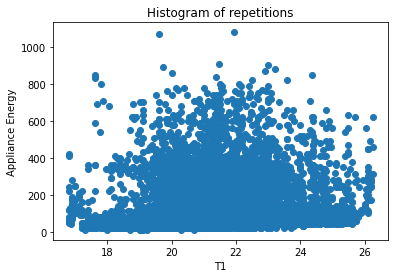

In [0]:
hist_elect = df.select("T1","Appliances").collect()
(x_values, y_values) = zip(*hist_elect)
plt.scatter(x_values, y_values)
plt.title('Histogram of repetitions')
plt.xlabel('T1')
plt.ylabel('Appliance Energy')
plt.show()

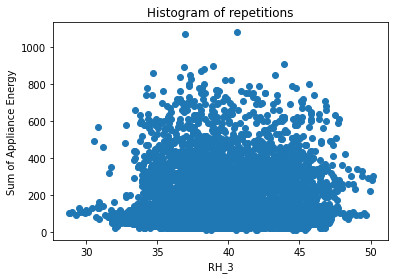

In [0]:
hist_elect = df.select("RH_3","Appliances").collect()
(x_values, y_values) = zip(*hist_elect)
plt.scatter(x_values, y_values)
plt.title('Histogram of repetitions')
plt.xlabel('RH_3')
plt.ylabel('Appliance Energy')
plt.show()

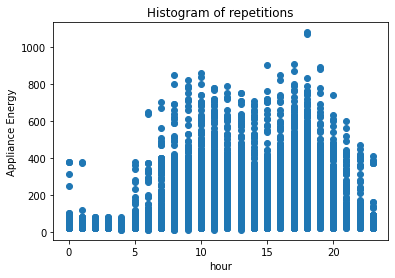

In [0]:
hist_elect = df.select("hour","Appliances").collect()
(x_values, y_values) = zip(*hist_elect)
plt.scatter(x_values, y_values)
plt.title('Histogram of repetitions')
plt.xlabel('hour')
plt.ylabel('Appliance Energy')
plt.show()

on most of the data there are a tiny amount of noise of outlier that can be removed and might improve our model

consider the 3 features if normalisation can benefits

In [0]:
df.select("hour","T1","RH_3","Appliances").show(10)

+----+---------+---------+----------+
hour| T1| RH_3|Appliances|
+----+---------+---------+----------+
 17| 19.89| 44.73| 60.0|
 17| 19.89| 44.79| 60.0|
 17| 19.89|44.933334| 50.0|
 17| 19.89| 45.0| 50.0|
 17| 19.89| 45.0| 60.0|
 17| 19.89|44.933334| 50.0|
 18| 19.89| 44.9| 60.0|
 18|19.856667| 44.9| 60.0|
 18| 19.79| 44.79| 60.0|
 18|19.856667|44.863335| 70.0|
+----+---------+---------+----------+
only showing top 10 rows

Normalisation can be done on T1 and RH_3